## Generate Signal and Cov Mat for MCMC.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from data_process import jackknife_label, load_calculation_data, calculate_jackknife_variance_global
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [40]:
z = 0
scale_factor = cosmos.Om(z) * cosmos.critical_density(z).to('M_sun/pc^3').value / h**2 * 1e6

## Cross Correlation

In [57]:
r_p_cross, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')

In [58]:
Nside_jack = 10
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)

In [59]:
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)

In [60]:
jack_cross = sampler_q['jackknife'].copy() / scale_factor

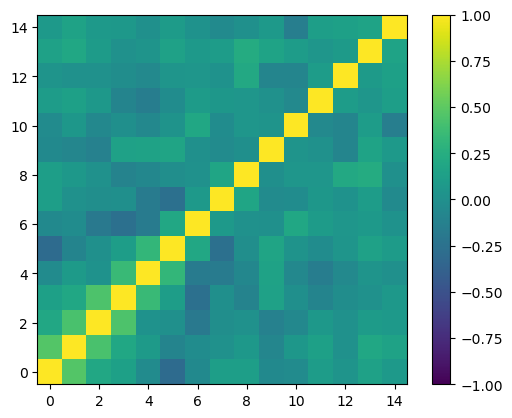

In [35]:
cov = np.cov(jack_cross, rowvar=False, ddof=0)
cov *= (jack_cross.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

## Auto Correlation

In [61]:
Nbins = 15
rp_min = 3
rp_max = 100

rp_bin_cross = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_cross = (rp_bin_cross[:-1]*rp_bin_cross[1:])**0.5

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin_auto = 10**(np.arange(-10, Nbins+1)*sep + np.log10(rp_min))
# rp_bin_auto = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_auto = (rp_bin_auto[:-1]*rp_bin_auto[1:])**0.5

Nbins = len(rp_bin_auto) - 1

In [62]:
jack_auto = np.load('../auto_correlation/quasar_lss_all.npy_auto.npy')

## Small Scale

In [63]:
import pandas as pd
signal_s = pd.read_csv('../auto_correlation/small_scale', index_col=0)

In [64]:
signal_s = signal_s.loc[3:10, :]            # apply all the cuts.
jack_auto = jack_auto[:, 6:-2]
jack_cross = jack_cross[:, :-2]

r_p_cross = r_p_cross[:-2]
r_p_auto = r_p_auto[6:-2]
r_p_small = np.array(signal_s['rp'])

print('cross rp range ', r_p_cross[0], r_p_cross[-1])
print('auto rp range ', r_p_auto[0], r_p_auto[-1])
print('small rp range ', r_p_small[0], r_p_small[-1])
r_p_auto = np.concatenate((r_p_small, r_p_auto))

cross rp range  3.371971377818346 55.74255561017865
auto rp range  1.3236796154715165 55.74255561017865
small rp range  0.046 0.981


In [65]:
jackknife_all = np.concatenate((jack_cross, jack_auto), axis=1)
cov = np.cov(jackknife_all, rowvar=False, ddof=0)
cov *= (jackknife_all.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))

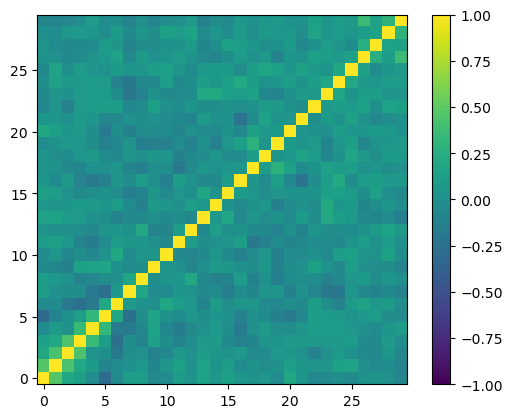

In [66]:
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

In [67]:
w_auto = np.concatenate((signal_s['wp'], jack_auto.mean(axis=0)))
w_cross = jack_cross.mean(axis=0)

In [68]:
nc = jack_cross.shape[1]
na = jack_auto.shape[1]
ns = len(signal_s)
cov_new = np.zeros(dtype=float, shape=(nc + na + ns, )*2)
cov_new[:nc, :nc] = cov[:nc, :nc]
cov_new[-na:, -na:] = cov[-na:, -na:]
cov_new[:nc, -na:] = cov[:nc, -na:]
cov_new[-na:, :nc] = cov[-na:, :nc]
wp_s_err = np.array(signal_s['wp_err'])
for i in range(ns):
    if np.isnan(wp_s_err[i]):
        cov_new[nc+i, nc+i] = 1e100
    else:
        cov_new[nc+i, nc+i] = wp_s_err[i]**2

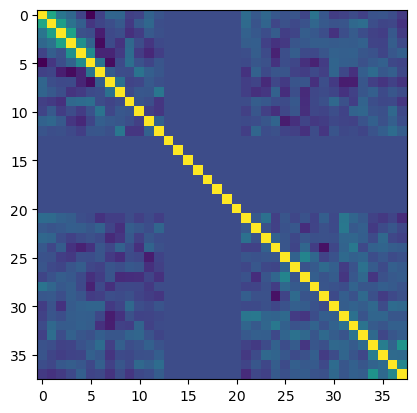

In [69]:
std_new = np.sqrt([cov_new[i,i] for i in range(len(cov_new))])
plt.imshow(cov_new / (std_new.reshape((-1, 1)) @ std_new.reshape((1, -1))))

In [74]:
with open('../mcmc/python/signal_small/signal.npy', 'wb')  as f:
    np.save(f, r_p_auto)
    np.save(f, w_auto)
    np.save(f, r_p_cross)
    np.save(f, w_cross)
np.save('../mcmc/python/signal_small/cov', cov_new)     # the std of nan is 1e100

In [71]:
std_cross = std_new[:len(w_cross)]
std_auto = std_new[len(w_cross):]

[]

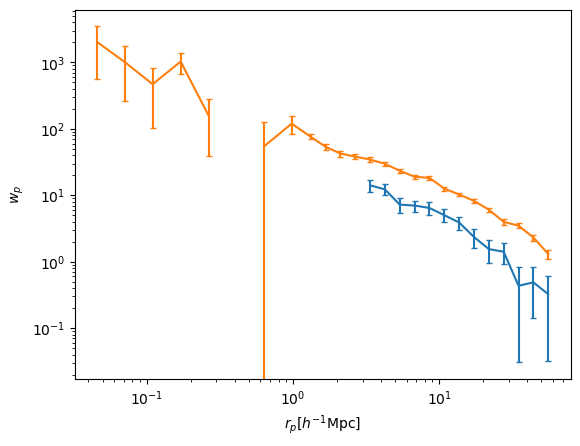

In [77]:
plt.errorbar(r_p_cross, w_cross, std_cross, capsize=2)
plt.errorbar(r_p_auto, w_auto, std_auto, capsize=2)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel('$w_p$')
plt.loglog()